# Sentiment Analysis on Political Subreddits

Reddit, a widely-used social media platform, hosts many communities (subreddits) where users discuss various political ideologies. This project aims to investigate the sentiment expressed in subreddits dedicated to general politics (r/politics), conservative viewpoints (r/conservative), and liberal viewpoints (r/liberal). Understanding the sentiment in these subreddits can provide valuable insights into the public mood and opinions on political matters, contributing to the broader field of digital humanities by revealing trends and patterns in digital discourse across different ideological perspectives.

## 1. Data Collection

We collected data from the subreddits r/politics, r/conservative, and r/liberal using the PRAW (Python Reddit API Wrapper) library. Specifically, we retrieved posts and comments from January 2023 to June 2024. The data collection focused on capturing a comprehensive snapshot of discussions within these subreddits over the specified period. This approach allowed us to analyze the overall sentiment and aggregated sentiment for each subreddit, as well as examine sentiment trends over time. The use of PRAW facilitated efficient extraction of the necessary data, ensuring that we could perform a detailed sentiment analysis on the collected comments.

First, use PRAW to set up reddit scraping API by input the credentials.

In [1]:
import praw
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import seaborn as sns

reddit = praw.Reddit(client_id="zcnETie-XsYr5rYoZeLGxQ",
                     client_secret="7ZG5G-SNTv2zH-aB5mj_73rraGeWwA",
                     user_agent="mac:ScrapingApp:0.1 (by u/Fancy-Ad9631)",
                     user_name="Fancy-Ad9631",
                     password="Xhq020407!@#")

Get the posts and comments for last year for each subreddits, from 2023/01 - 2024/06 by using the PRAW api. 

In [2]:
def get_comments(subreddit_name, start_date, end_date):
    subreddit = reddit.subreddit(subreddit_name)
    comments = []

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    for submission in tqdm(subreddit.top(time_filter="all", limit=None)):
        submission_date = datetime.fromtimestamp(submission.created_utc)
        
        if start_date <= submission_date <= end_date:
            submission.comments.replace_more(limit=0)
            
            for comment in submission.comments.list():
                comments.append([comment.body, datetime.fromtimestamp(comment.created_utc)])
                
    return pd.DataFrame(comments, columns=['Comment', 'Timestamp'])
start_date = '2023-01-01'
end_date = '2024-06-01'
politics_df = get_comments('politics', start_date, end_date)
conservative_df = get_comments('conservative', start_date, end_date)
liberal_df = get_comments('liberal', start_date, end_date)

997it [02:16,  7.32it/s]
993it [01:19, 12.44it/s]
1000it [00:35, 28.37it/s]


Convert the comments to csv file and save them for further processing, so we don't need to scrape them again.

In [3]:
politics_df.to_csv('politics_comments.csv', index=False)
conservative_df.to_csv('conservative_comments.csv', index=False)
liberal_df.to_csv('liberal_comments.csv', index=False)

Read these csv files, asynchrously.

In [4]:
politics_df = pd.read_csv('politics_comments.csv')
conservative_df = pd.read_csv('conservative_comments.csv')
liberal_df = pd.read_csv('liberal_comments.csv')

## 2. Data Cleaning
To ensure accurate sentiment analysis, we undertook a comprehensive data cleaning process. The steps included:

- Removing Whitespace: Stripping leading and trailing whitespace from each comment to ensure uniformity.

- Lowercasing Text: Converting all text to lowercase to avoid treating words with different cases as distinct entities.

- Removing Punctuation: Eliminating punctuation marks to focus on the words themselves, which are more relevant for sentiment analysis.

- Removing Non-ASCII Characters: Filtering out non-ASCII characters to prevent issues with text processing tools that may not handle such characters properly.

- Removing URLs: Deleting any URLs from the comments to eliminate irrelevant content that could skew the sentiment analysis.

- Removing Numbers: Filtering out numeric characters, which do not contribute to the sentiment and could introduce noise.

- Converting Emoji: Transforming emojis into their textual descriptions using the emoji library to capture their sentiment.

- Removing Extra Whitespace: Replacing multiple spaces with a single space to maintain consistency in text formatting.

- Removing Stop Words: Eliminating common stop words (e.g., "and," "the," "is") using NLTK’s stopwords list to focus on the meaningful content.

- Lemmatization: Applying lemmatization to reduce words to their base or root form (e.g., "running" to "run"), which helps in standardizing the text and improving the sentiment analysis accuracy.

By performing these steps, we ensured that the text data was clean, consistent, and ready for accurate sentiment analysis using the VADER tool. This rigorous preprocessing was essential for extracting meaningful insights from the Reddit comments.

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(df):
    df['Comment'] = df['Comment'].str.strip()  # Remove leading and trailing whitespace
    df['Comment'] = df['Comment'].str.lower()  # Convert to lowercase
    df['Comment'] = df['Comment'].str.replace('[^\w\s]', '')  # Remove punctuation
    df['Comment'] = df['Comment'].str.encode('ascii', 'ignore').str.decode('ascii')  # Remove non-ASCII characters
    df['Comment'] = df['Comment'].str.replace(r'http\S+|www.\S+', '', case=False)  # Remove URLs
    df['Comment'] = df['Comment'].str.replace('\d+', '')  # Remove numbers
    df['Comment'] = df['Comment'].apply(lambda x: emoji.demojize(x))  # Convert emoji to text
    df['Comment'] = df['Comment'].replace('\s+', ' ', regex=True)  # Remove extra whitespace
    
    
    # Remove stop words and lemmatize
    df['Comment'] = df['Comment'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))
    
    
    return df

# Apply the cleaning function to each dataframe
politics_df = clean_text(politics_df)
conservative_df = clean_text(conservative_df)
liberal_df = clean_text(liberal_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\94987\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\94987\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\94987\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


## 3. Sentiment Analysis
We initialize the NLTK VADER sentiment analyzer and define a function to analyze the sentiment of each comment. It then applies this function to each subreddit dataframe, adding a 'Sentiment' column with the compound sentiment scores.

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(df):
    df['Sentiment'] = df['Comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
    return df

politics_df = analyze_sentiment(politics_df)
conservative_df = analyze_sentiment(conservative_df)
liberal_df = analyze_sentiment(liberal_df)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\94987\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### 1. Use Matplotlib and Seaborn to create a bar plot of the average sentiment for each subreddit. The plot_overall_sentiment function calculates the mean sentiment for each dataframe and then plots these values.

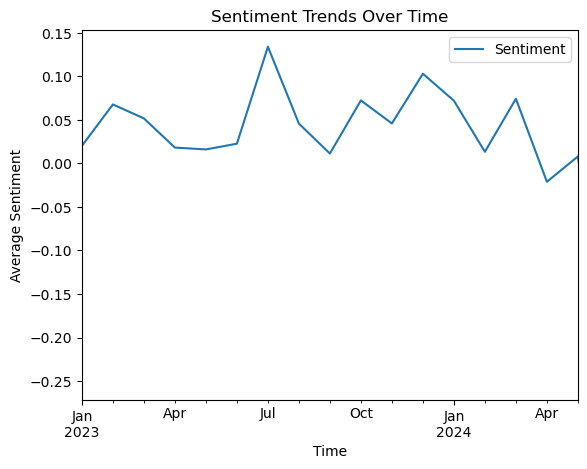

In [9]:
import matplotlib.pyplot as plt
combined_df = pd.concat([politics_df, conservative_df, liberal_df]).reset_index()
def plot_sentiment_trends(df, label):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)
    df['Sentiment'].resample('M').mean().plot(label=label)
    plt.legend()
    plt.title('Sentiment Trends Over Time')
    plt.ylabel('Average Sentiment')
    plt.xlabel('Time')
    plt.xlim(['2023-01-01', '2024-05-31'])
    plt.show()

plot_sentiment_trends(combined_df, 'Sentiment')

The sentiment trends over time for the combined subreddits r/politics, r/conservative, and r/liberal show significant fluctuations from January 2023 to April 2024, reflecting various political events that shaped public discourse. Notably, there is a positive spike in July 2023, which could be attributed to events such as the Supreme Court's decision to end affirmative action, which was supported by 61% of U.S. voters​ [(Morning Consult Pro)][website1]​. Additionally, July also saw the sentencing of the El Paso Walmart shooter, which might have influenced positive sentiments due to the justice served in a high-profile case​ [(InfoPlease)][website2]​. The dip in sentiment around October 2023 could correlate with contentious issues like the ongoing political debates and the implications of various rulings and legislative changes, such as the significant legislative activities surrounding reproductive rights and restrictions on medical care for transgender youth​ [(InfoPlease)][website3]​​. Overall, the sentiment over time oscillates, reflecting the public's reaction to these critical political developments, demonstrating the unstable nature of political discourse on Reddit.

[website1]: https://pro.morningconsult.com/analyst-reports/july-2023-us-political-trends-chart-pack
[website2]: https://www.infoplease.com/current-events/2023/july-us-news
[website3]: https://www.infoplease.com/current-events/2023/october-us-news

#### 2. Get the most positive/negative sentiments for each subreddits.

In [13]:
def truncate_text(text, max_length=1000):
    """Truncate text to a maximum length with an ellipsis if it's too long."""
    if len(text) > max_length:
        return text[:max_length] + '...'
    else:
        return text
pd.options.display.max_colwidth = None
def get_extreme_sentiments(df, label, max_length=1000):
    df = df.reset_index()
    most_positive = df.loc[df['Sentiment'].idxmax()]
    most_negative = df.loc[df['Sentiment'].idxmin()]
    
    extreme_df = pd.DataFrame({
        'Subreddit': [label, label],
        'Type': ['Most Positive', 'Most Negative'],
        'Comment': [truncate_text(most_positive['Comment'], max_length), truncate_text(most_negative['Comment'], max_length)],
        'Sentiment': [most_positive['Sentiment'], most_negative['Sentiment']],
        'Timestamp': [most_positive['Timestamp'], most_negative['Timestamp']]
    })
    
    return extreme_df

politics_extremes = get_extreme_sentiments(politics_df, 'Politics')
conservative_extremes = get_extreme_sentiments(conservative_df, 'Conservative')
liberal_extremes = get_extreme_sentiments(liberal_df, 'Liberal')

extreme_sentiments_df = pd.concat([politics_extremes, conservative_extremes, liberal_extremes], ignore_index=True)

extreme_sentiments_df

,Subreddit,Type,Comment,Sentiment,Timestamp
0,Politics,Most Positive,"commented elsewhere month back, trying share story around can; >story time: got ""tricked going drag bar(?) & i've never really known share story i'm gonna leave here, >a year ago, started getting stand-up. traveling 60-70 minute night go 2-4 open mics week running around city. one night year ago, covid. talking couple comedian city. wasting like $40 gas open mics bar im buying drink go up. i'm maine comedy scene great time unexperienced comedian like myself. >the two em' mentioned actually knew club super popular open mics week near me. excited. night went & saved gps. went bar set week. >what failed tell me, comedy bar. **drag show bar**. one gay/trans(?) men & woman come & express freely. open mic? drag show people perform. >now. fair. clocked something saw line incredibly handsome woman lined door.. maine, & mirror. judge? /s >the second walked though. could tell someone played 'prank' me. comedy club. >i actually gonna leave. felt bit shocked. i'm small town, never type environment...",0.9974,2023-03-22 05:49:09
1,Politics,Most Negative,"biblical killing instructions: kill adulterer (lev 20:10) kill witch (ex 22:18) kill blasphemer (lev 24:14) kill false prophet (zech 13:3) kill fortune-tellers (lev 20:27) kill anyone sin (ezek 18:4) kill curious (1 sam 6:19-20) kill gay (lev 20:13, rom 1:21-32) kill non-hebrews (dt 20:16-17) kill son sinner (isaiah 14:21) kill non-believers (2 chron 15:12-13) kill anyone curse god (lev 24:16) kill child hit parent (ex 21:15) kill child disobey parent (dt 21:20) kill work sabbath (ex 31:15) kill disobedient child (ex 21:17, mk 7:10) kill stranger close church (num 1:48-51) kill male winning battle (dt 20:13) kill curse father mother (lev 20:9) kill men sex men (lev 20:13) kill bride discovered virgin (dt 22:21) kill worship wrong god (num 25:1-9) kill anyone observe sabbath (ex 31:14) kill everybody town worship wrong god (dt 13:13-16) importantly (/s): kill anyone kill anyone (lev 24:17).",-0.9993,2023-03-23 19:32:56
2,Conservative,Most Positive,"locked state covid. came lockdown line typical red states. call ""beautifully"". best, expected. good though herald face valid criticism levied him. also pretty strange blame trump lockdown duration president control state lockdown - state do. okay, like trump also really matter discussion. floridian economy growing well fastest growing state economy - idaho is. florida's primarily driven population migration [not resulting great ppp adjusted number especially south](https://www.axios.com/local/miami/2023/11/14/cost-of-living-south-florida-high), unlike idaho example. e-verify mandatory all, 25 employee more. company size typically already one comply. illegal employment tends happen small business level contract level - medium large companies. actually even always illegal contract sphere that's another topic. win, small win guy practically undisputed super majority state. surplus - state surplus moment. due higher expected nationwide tax revenue gain. read here; https://budgetblog.nasbo....",0.9907,2023-11-15 18:44:36
3,Conservative,Most Negative,"surprised. guess cynical enough, thought supposedly educated 12 juror manhattan could look past hatred trump judge fact presented. fact demand acquittal. standard guilty beyond reasonable doubt could logically met. case drowning reasonable doubt. reasonable doubt oj simpson didnt murder wife, reasonable doubt trump guilty convoluted crime nyc prosecutor dreamed up. trump guilty, following needed true: a. trump approve cohens payment stormy daniels. cohen testified this, witness said cohen often acted without approval. cohens testimony credible, since lied stand. b. trump know paying cohen specifically reimburse him, signed check. trump didnt even know cohen stealing him. c. trump knowingly committed fraud business record labeled legal expenses. according nycs law, enough record inaccurate. inaccuracy must due intentional fraud crime 

We can see that the comments from r/politics, r/conservative, and r/liberal subreddits reveals sharp contrasts in sentiment.  In the "Politics" subreddit, the most positive comment recounts a personal story about a surprising visit to a drag show bar, showcasing acceptance and humor. The most negative comment harshly critiques various biblical instructions for their perceived cruelty. In the "Conservative" subreddit, the most positive comment praises state-level responses to COVID-19 and economic growth, whereas the most negative comment expresses cynicism about the judicial process in a high-profile case involving Donald Trump. In the "Liberal" subreddit, the most positive comment discusses the potential for new political parties to form and succeed, while the most negative comment lists legal charges against Trump, highlighting the perceived seriousness of his alleged crimes.

Based on the extracted comments, we can infer several characteristics about each subreddit. The "Politics" subreddit shows an appreciation for personal experiences and inclusive topics, with positive discussions often revolving around personal growth and acceptance, while negative discussions engage critically with controversial ethical and religious issues. The "Conservative" subreddit values pragmatic governance and conservative policies, with positive comments highlighting successful state-level initiatives and economic growth, whereas negative comments express distrust in the legal system, especially regarding perceived political bias against conservative figures. The "Liberal" subreddit focuses on political reform and accountability, with positive comments discussing potential new political parties and systemic changes, while negative comments emphasize the legal and ethical scrutiny of political figures like Donald Trump. Overall, these subreddits reflect strong ideological leanings, engage deeply with controversial topics, and exhibit clear community values aligned with their respective political perspectives.

#### 3. Get the overall sentiment in each subreddit for the past year

c:\Users\94987\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


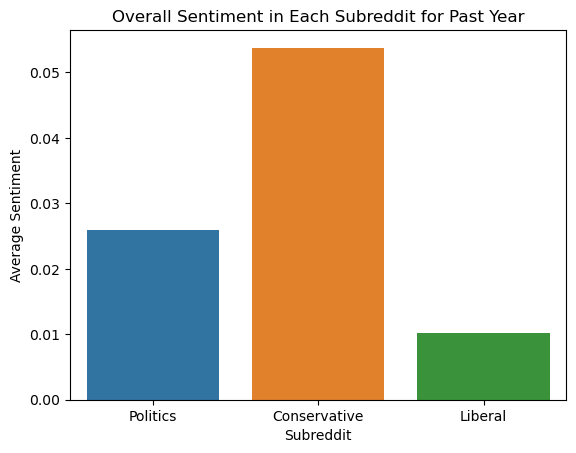

In [16]:
def plot_overall_sentiment(*dfs, labels):
    sentiments = [df['Sentiment'].mean() for df in dfs]
    sns.barplot(x=labels, y=sentiments)
    plt.xlabel('Subreddit')
    plt.ylabel('Average Sentiment')
    plt.title('Overall Sentiment in Each Subreddit for Past Year')
    plt.show()

plot_overall_sentiment(politics_df, conservative_df, liberal_df, labels=['Politics', 'Conservative', 'Liberal'])

The bar plot reveals distinct differences in sentiment across three subreddits—Politics, Conservative, and Liberal—over the past year. The Conservative subreddit shows the highest average sentiment, suggesting a generally positive atmosphere among its users, which could be attributed to the strong support for Trump and optimism about his political prospects. In contrast, the Liberal subreddit has the lowest average sentiment, indicating a more critical or less positive tone in discussions. This may reflect growing dissatisfaction with Biden among liberal users, possibly due to unmet expectations or controversial policies. The Politics subreddit, with a moderate average sentiment score, reflects a balanced mix of positive and negative sentiments, likely due to the diverse range of political opinions represented. These variations in sentiment highlight the different emotional climates within each political community on Reddit and provide insights into the current political landscape.

#### 4. Get overall sentiment across all three subreddits.

In [15]:
combined_df['Sentiment'].mean()

0.03394211808541129

To gauge the general mood across r/politics, r/conservative, and r/liberal, we calculated the average sentiment score of comments from all three subreddits. The overall sentiment score was approximately 0.034, indicating a slightly positive sentiment across the combined dataset. This suggests that despite the ideological differences among these communities, the general tone of discussions on Reddit tends to lean slightly towards positive or neutral sentiments.

### 5. Additional Analysis over Word Frequencies
To better understanding the discussion topics for each subreddits, word cloud would be useful to see what are some common topics in each subreddit.

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, title=None):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, size=20)
    plt.show()

In [19]:
politics_comments = ' '.join(politics_df['Comment'].tolist())
conservative_comments = ' '.join(conservative_df['Comment'].tolist())
liberal_comments = ' '.join(liberal_df['Comment'].tolist())

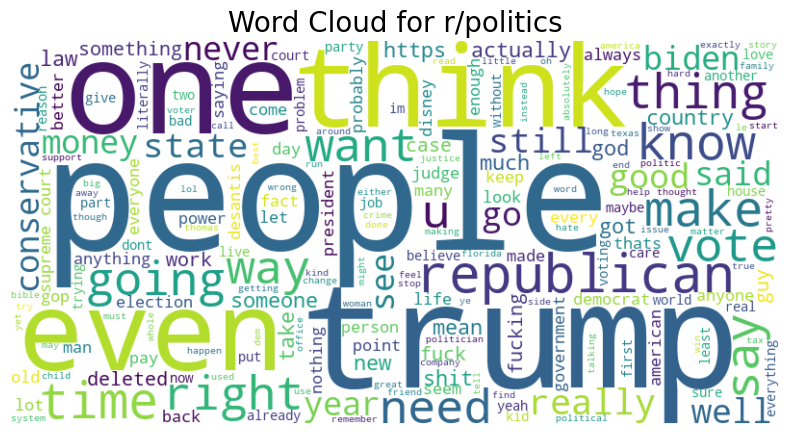

In [21]:
generate_wordcloud(politics_comments, title='Word Cloud for r/politics')

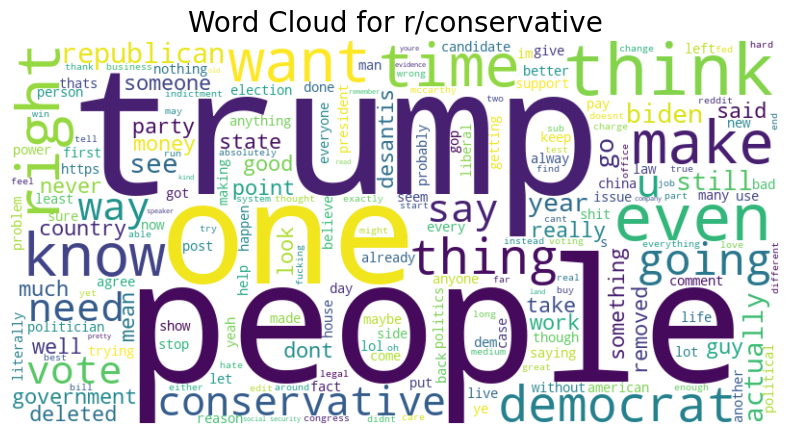

In [22]:
generate_wordcloud(conservative_comments, title='Word Cloud for r/conservative')

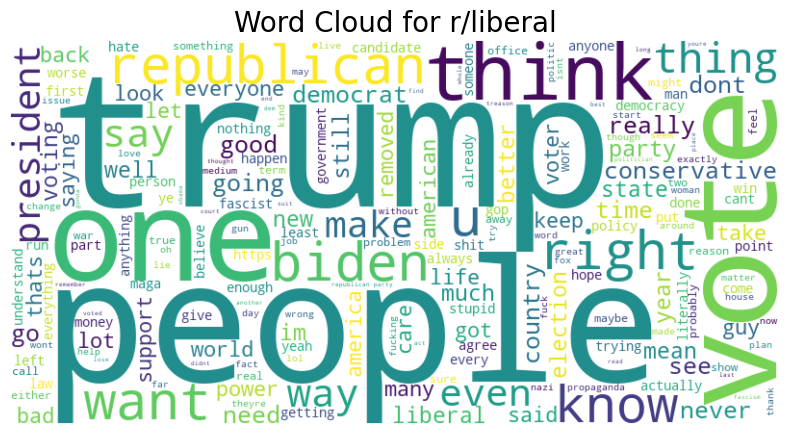

In [23]:
generate_wordcloud(liberal_comments, title='Word Cloud for r/liberal')

The word clouds for the subreddits r/liberal, r/conservative, and r/politics reveal notable patterns in the language used by members of these communities. In all three word clouds, the names "Trump" and "people" are among the most prominent words, indicating frequent discussions about the former president and general references to individuals. Words like "think," "one," "want," "make," and "know" are also common across the subreddits, suggesting that participants often engage in discourse about beliefs, desires, and actions. The presence of words such as "vote," "president," and "republican" highlights the focus on political figures and electoral processes. Despite the commonalities, each subreddit also has unique terms reflecting its ideological leanings: for instance, "conservative" appears more prominently in r/conservative, whereas r/liberal features words like "democrat" and "biden." These distinctions illustrate the different priorities and concerns of each political group while emphasizing shared topics of interest in the broader political discourse.

## 4. Conclusion

Overall, this analysis of sentiment across the subreddits r/politics, r/conservative, and r/liberal has successfully revealed significant differences in the emotional tone and discourse within these communities. By applying sentiment analysis and visualizing the results, this research highlights the distinct ideological leanings and emotional climates of these subreddits, providing valuable insights into the public mood and political discussions on Reddit. These findings are valuable for understanding the details of digital political discourse and for informing future studies in digital humanities and political science. However, limitations such as potential biases in data collection, the inherent constraints of the VADER sentiment analysis tool, and the evolving nature of online discussions must be acknowledged. Future research could address these limitations by employing more sophisticated sentiment analysis techniques and expanding the scope of data collection to provide a more comprehensive view of online political sentiment.